<a href="https://colab.research.google.com/github/agentydragon/sched/blob/master/Explore_Anki_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import timedelta
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
conn = sqlite3.connect('/content/gdrive/My Drive/collection.anki2')
data = []
for row in conn.execute('SELECT id, cid, ease, time, type FROM revlog;'):
  id, cid, ease, time, type = row
  data.append((pd.Timestamp(id, unit='ms'), cid, ease, time, type))
df = pd.DataFrame(data, columns = ['id', 'cid', 'ease', 'time', 'type'])

Let's get the number of cards I have.

In [7]:
print(len(pd.unique(df['cid'])))

34537


Forgetting curves
==

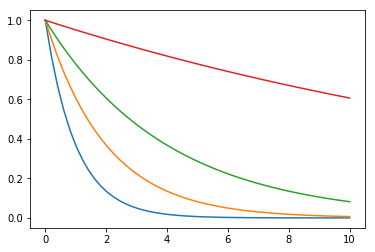

In [8]:
x = np.linspace(0.0, 10.0)
plt.plot(x, np.exp(-x), x, np.exp(-0.5 * x), x, np.exp(-0.25 * x), x, np.exp(-0.05 * x))

In [0]:
def get_card_reviews(cid):
  card_reviews = df[df.cid == cid]
  card_reviews = card_reviews.loc[:, ['id', 'ease', 'time', 'type']]
  card_reviews['correct'] = card_reviews.ease > 1
  card_reviews = card_reviews.loc[:, ['id', 'correct']]
  card_reviews.head()
  card_reviews['diff'] = card_reviews['id'].diff()
  return card_reviews[~card_reviews['diff'].isnull()]

def get_sample_card_ids(n):
  return pd.Series(pd.unique(df['cid'])).sort_values().sample(n=n, random_state=1).to_numpy()

Card difficulty - making lambda smaller/bigger on win/loss
===

Model: probability of getting a card right is $\hat{p} = e^{-\lambda \cdot t}$.
If you get a card right, $\lambda$ gets multiplied by $w$, and if you get it wrong, it gets multiplied by $l$.
The initial value of $\lambda$ is $\lambda_1$. $t$ is measured in floating-point days since last review. Parameters are $[\lambda_1, w, l]$ and they are initialized with ones. To prevent taking logs of numbers very close to 0, we cap $\hat{p}$ between 0.001 and 0.998. Here we try to fit one global model.

We optimize $H(p, \hat{p})$ by stochastic gradient descent. The model is trained on 1000 random cards.

In [5]:
lambda1 = tf.Variable(1.0, name="lambda1", trainable=True)
win_p = tf.Variable(1.0)
loss_p = tf.Variable(1.0)
l = lambda1
losses = []
probabilities = []

def build_losses_for_reviews(card_reviews):
  l = lambda1
  for index, row in card_reviews.iterrows():
    #print(row)
    diff_seconds = row['diff'].total_seconds()
    diff_days = diff_seconds / 86400.0
    current_probability = 0.998 * tf.exp(-l * diff_days) + 0.001
    probabilities.append(current_probability)

    if row['correct']:
      # we predicted probability current_probability --> if it was 1, do nothing
      loss_bit = -tf.log(current_probability)
      losses.append(loss_bit)
      l = l * win_p
    else:
      loss_bit = -tf.log(1.0 - current_probability)
      losses.append(loss_bit)
      l = l * loss_p
      
for card in get_sample_card_ids(1000):
  build_losses_for_reviews(get_card_reviews(card))

loss = tf.reduce_sum(losses) / len(losses)
# Making training rate higher than 0.01 leads to shooting out to NaNs.
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
variables = [lambda1, win_p, loss_p]
train_op = opt.minimize(loss, var_list=variables)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(1000):
    metadata = tf.RunMetadata()
    sess.run(train_op)
    if i % 10 == 0:
      print("after round", i, sess.run(variables), "loss=", sess.run(loss))
  
  print('Final:')
  print(sess.run(variables))
#  print('Probs: ', sess.run(probabilities))
#  print('Loss: ', sess.run(loss))
    

Instructions for updating:
Colocations handled automatically by placer.
after round 0 [0.9948127, 0.9265158, 0.9574966] loss= 2.7989676
after round 10 [0.9554716, 0.68867004, 0.9956161] loss= 2.1950507
after round 20 [0.9174773, 0.481618, 1.0700268] loss= 1.695402
after round 30 [0.88792366, 0.32574418, 1.129935] loss= 1.406148
after round 40 [0.8711519, 0.25430214, 1.1740621] loss= 1.3325257
after round 50 [0.8594233, 0.21829039, 1.2124249] loss= 1.3035784
after round 60 [0.8498727, 0.1991274, 1.2484754] loss= 1.285962
after round 70 [0.84135073, 0.18910672, 1.2822889] loss= 1.2728657
after round 80 [0.8332972, 0.18492456, 1.313216] loss= 1.2624648
after round 90 [0.82545394, 0.18372652, 1.3425608] loss= 1.2532506
after round 100 [0.8176308, 0.184057, 1.3704917] loss= 1.2448472
after round 110 [0.8097611, 0.18538415, 1.3975385] loss= 1.2368796
after round 120 [0.80181926, 0.18691508, 1.4235996] loss= 1.2294636
after round 130 [0.79371446, 0.18824933, 1.4475842] loss= 1.2230388
after r

One training gave the result: $\lambda_1\approx 0.2016$, $w\approx 0.2432$, $l\approx 1.8975$.

Looks like we are bottoming out at a cross-entropy of about 1.1 on each review. From $-\log(x)=1.1$, we have $x=e^{-1.1}\approx 0.33$. So that's about as much entropy as if we predicted the probability of a true event at $1/3$.

Questions:

* What if I let this run longer?
* Can I do constrained optimization in Tensorflow, so that $\lambda$ in model below is fixed to positive?
* Would other optimizers be faster?

Extension ideas:

* Would it be useful to model per-card state?
* Compute test-set loss on a withheld set of cards
* Operate on batches; construct one computation graph for one card, do not throw them all into the graph.
* Anki's SR algorithm uses the *interval*, the *card difficulty* and the *number of last successful reviews*. Would integrating the number of last successful reviews into the model help?
* It would be nice to get a visualization of how the probabilities look for a given card, with review points.
* It might be helpful to distinguish between "learn" reviews, "relearn" reviews and others.

Basic model - the same forgetting curve starting after every revision
===

This one currently does not work, and tends to somehow run into NaN's. I should fix that at some point.

In [17]:
lambda1 = tf.Variable(1.0, name="lambda1", trainable=True)
losses = []
probabilities = []

def build_losses_for_reviews(card_reviews):
  l = lambda1
  for index, row in card_reviews.iterrows():
    #print(row)
    diff_seconds = row['diff'].total_seconds()
    diff_days = diff_seconds / 86400.0
    current_probability = 0.9998 * tf.exp(-l * diff_days) + 0.0001
    probabilities.append(current_probability)

    if row['correct']:
      # we predicted probability current_probability --> if it was 1, do nothing
      loss_bit = -tf.log(current_probability)
      losses.append(loss_bit)
    else:
      loss_bit = -tf.log(1.0 - current_probability)
      losses.append(loss_bit)

for card in get_sample_card_ids(10):
  build_losses_for_reviews(get_card_reviews(card))

loss = tf.reduce_sum(losses) / len(losses)
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
variables = [lambda1, lambda2]
train_op = opt.minimize(loss, var_list=variables)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(100):
    loss_value = sess.run(loss)
    if np.isnan(loss_value):
      print('Reached NaN!')
    sess.run(train_op)
    if i % 10 == 0:
      print('Probs: ', sess.run(probabilities))
      print('Loss: ', loss_value)
      print("after round", i, sess.run(variables))
  
  print('Final:')
  print(sess.run(variables))
  print('Probs: ', sess.run(probabilities))
  print('Loss: ', loss_value)
    
    
# TODO: why does the lambda get optimized down into negative numbers? >:(

Probs:  [0.983854, 0.9731835, 0.6304561, 0.6378329, 0.00010707023, 0.00010000005, 1e-04, 0.9870601, 0.98080695, 0.00013492166, 0.8915018, 0.80357873, 0.11786603, 0.018518459, 0.0012241048, 0.9928614, 0.9825855, 0.33358455, 0.9917703, 0.9197108, 0.83498573, 0.08052481, 0.12274151, 0.062798, 0.0043989536, 0.00038960838, 0.000100002035, 1e-04, 1e-04, 0.9921068, 0.91639555, 1e-04, 1e-04, 1e-04, 0.94125444, 0.52467954, 0.00011422679, 1e-04, 1e-04, 0.99875134, 0.9923497, 0.98533535, 0.018801449, 0.0022194902, 0.000100337245, 1e-04, 1e-04, 0.9986431, 0.69440746, 0.6172623, 0.00010000204, 1e-04, 1e-04, 0.9929457, 0.6246892, 0.00010000494, 1e-04, 1e-04, 0.9922447, 0.95966107, 0.20310037, 0.05310323, 0.000100000056, 1e-04, 1e-04, 0.9995254, 0.9995709, 0.62954056, 0.014662209, 0.00034591663, 0.00010002474, 1e-04, 1e-04, 0.85582453, 0.89602727, 0.8652565, 0.00012321361, 0.992933, 0.99084216, 0.9657137, 0.00010600637, 0.98374814, 0.98277557, 0.15442748, 0.0008701521, 0.00022042947, 0.00010003694, 1